# Experiments

What kind of question would we like to answer ... 

 Overall, these experiments will help use to estimate by how much the use of the upper bound in computing the age latency can be beneficial. 
 
 there are two case to consider, optimum and eapproximate. 
 First the optimum case, by how much using the lower can accelerate the search (in term of iterations, or more generally in term of execution time). 
 Secondly by introducing the lower bound to our mechanism, we also enable approximate solution with garanties in delta. By considering several situations of acceptable errors (such as 1%, 5%, 10%, 15%), by how much the computation of age latency can be improved. 
 


In [1]:
!mkdir -p data
!if [ ! -e data/automotive.csv ]; then echo Not found; fi

In [2]:

!if [ ! -e data/automotive.csv ]; then ../build/src/benchmarkAgelatency   -kind automotive -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -detailed -logfile data/automotive.csv; fi


In [3]:

!if [ ! -e data/harmonic.csv ]; then ../build/src/benchmarkAgelatency   -kind harmonic -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -detailed -logfile data/harmonic.csv; fi


In [4]:

!if [ ! -e data/generic.csv ]; then ../build/src/benchmarkAgelatency   -kind generic -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -detailed -logfile data/generic.csv; fi


In [5]:

!if [ ! -e data/automotivediti.csv ]; then ../build/src/benchmarkAgelatency   -kind automotive -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -DiEqualTi -detailed -logfile data/automotivediti.csv; fi


In [6]:

!if [ ! -e data/harmonicditi.csv ]; then ../build/src/benchmarkAgelatency   -kind harmonic -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -DiEqualTi -detailed -logfile data/harmonicditi.csv; fi


In [7]:

!if [ ! -e data/genericditi.csv ]; then ../build/src/benchmarkAgelatency   -kind generic -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -DiEqualTi -detailed -logfile data/genericditi.csv; fi


In [8]:

!if [ ! -e data/containsAnomalies.csv ]; then ../build/src/benchmarkAgelatency -begin_n 4 -end_n 5 -kind generic -step_n 1 -detailed -iter_count 1 -sample_count 10000 -logfile data/containsAnomalies.csv; fi


In [9]:

!if [ ! -e data/containsAnomalies_diti.csv ]; then ../build/src/benchmarkAgelatency -begin_n 4 -end_n 5 -kind generic -step_n 1 -detailed -iter_count 1 -sample_count 10000 -logfile data/containsAnomalies_diti.csv -DiEqualTi; fi


In [10]:

!if [ ! -e data/seek3.csv ]; then ../build/src/benchmarkAgelatency -begin_n 3 -end_n 5 -kind generic -step_n 1 -detailed -iter_count 1 -sample_count 10000 -logfile data/seek3.csv; fi


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def openLog(filename):
    toIntList = lambda x: [int(y) for y in x.strip("[]").split(",")]
    df = pd.read_csv(filename, sep=";",
                     converters={
                         "ExpansionVertex": toIntList,
                         "ExpansionEdges": toIntList,
                         "LowerBounds": toIntList,
                         "UpperBounds": toIntList,
                     }
                    )

    # Remove zero-task cases, annoying and useless.
    df = df[df["n"] > 0]
    
    # Rename kinds
    kind_name = {1:"generic", 2:"harmonic", 3:"automotive"}
    df["kind"] = df["kind"].apply(lambda x : kind_name[x])
    
    
    assert("seed" in df.columns)
    df.LowerBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.LowerBounds]  , axis = 1)
    df.UpperBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.UpperBounds]  , axis = 1)
    df.ExpansionVertex = df.apply(lambda x :  [y/(x.sum_n+2) for y in x.ExpansionVertex]  , axis = 1)

    
    assert(df.ExpansionVertex.apply(max).max())
    assert(df.LowerBounds.apply(max).max())
    assert(df.UpperBounds.apply(max).max())

    df["BoundsDistances"] = df.apply(lambda x : [abs( l - r ) for (l,r) in zip(x.LowerBounds,x.UpperBounds)], axis=1)
    df["bounds_shift"] = df.apply ( lambda x : (x["LowerBounds"].index(1) - x["UpperBounds"].index(1)) if x["LowerBounds"].count(1) else None , axis=1)
    df["early_bounds"] = df.apply ( lambda x : ((x["LowerBounds"].index(1) + 1< len(x["LowerBounds"])) and  (x["UpperBounds"].index(1) + 1 < len(x["UpperBounds"]) ))  if x["LowerBounds"].count(1) else None , axis=1)
    df["filename"] = filename
    df['remain_time'] = (df["total_time"] - df["gen_time"] - df["lbp_time"] - df["ubp_time"])
    return df.reset_index()

df = openLog("data/automotive.csv")

In [12]:
def openLogs(filelist):
    df = None
    for f in filelist:
        df = pd.concat([df,openLog(f)], ignore_index=True)
    return df
df = openLogs(["data/automotive.csv", "data/harmonic.csv", "data/generic.csv"])

##  What is the maximum and minimum error we get from the first lower bound compared 

with the final latency ?

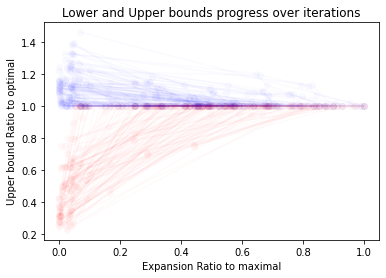

In [13]:
def lower_upper_detailled (df, alpha = None) :
    if not alpha :
        alpha = max ( 0.02,  1.0 / len(df) )
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.LowerBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "r", alpha = alpha)
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.UpperBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "b", alpha = alpha)
    _ = plt.xlabel("Expansion Ratio to maximal")
    _ = plt.ylabel("Upper bound Ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations")
lower_upper_detailled (df)

In [14]:
print(df.columns)
print(df.IterationCount.max())

Index(['index', 'seed', 'kind', 'DiEqTi', 'n', 'm', 'sum_n', 'AgeLatency',
       'IterationCount', 'ExpansionVertex', 'ExpansionEdges', 'LowerBounds',
       'UpperBounds', 'gen_time', 'lbp_time', 'ubp_time', 'total_time',
       'BoundsDistances', 'bounds_shift', 'early_bounds', 'filename',
       'remain_time'],
      dtype='object')
7


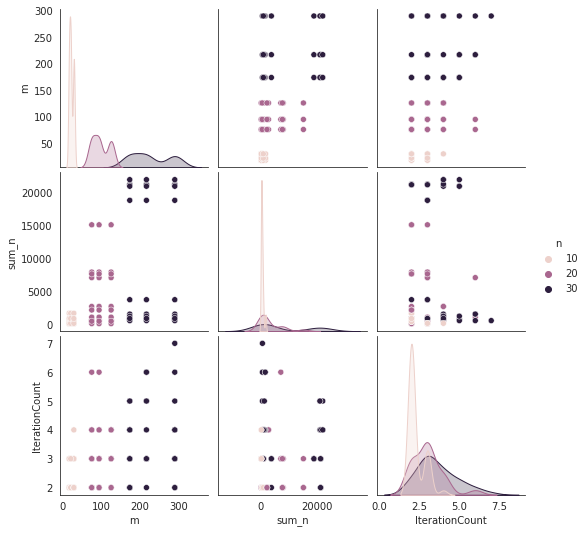

In [15]:
import seaborn as sns

def summarizePlots(df) :
    with sns.axes_style('white'):
        #_ = sns.jointplot("n", "m", data=df, kind='hex')
        _ = sns.pairplot(data=df[[ "n","m",  "sum_n", "IterationCount"]], hue="n")
summarizePlots(df)

## Study of the bounds

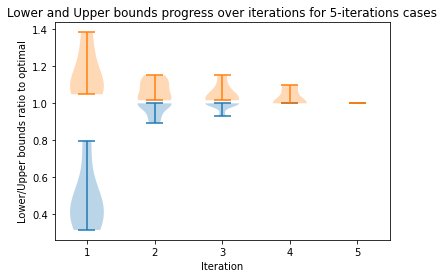

In [16]:
def plotBoundsByIteration(df, itercount) :
    sdf  =  df[df.IterationCount == itercount]
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(itercount)))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(itercount)))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    
plotBoundsByIteration(df, 5)
_ = plt.title("Lower and Upper bounds progress over iterations for 5-iterations cases")

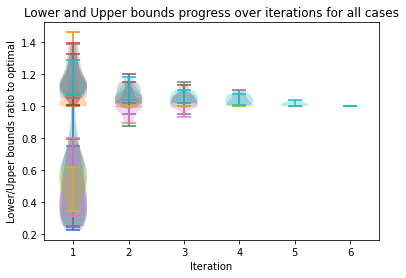

In [17]:
for it in range(1,df.IterationCount.max() + 1) :
    if len(df[df.IterationCount == it]) > 1:
        plotBoundsByIteration(df, it)
_ = plt.title("Lower and Upper bounds progress over iterations for all cases")

In [18]:
def plotBounds(df) :
    sdf = df.copy()
    sdf.LowerBounds = sdf.apply (lambda x : x.LowerBounds + (df.IterationCount.max() - x.IterationCount)*x.LowerBounds[-1:], axis = 1)
    sdf.UpperBounds = sdf.apply (lambda x : x.UpperBounds + (df.IterationCount.max() - x.IterationCount)*x.UpperBounds[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations for all cases")

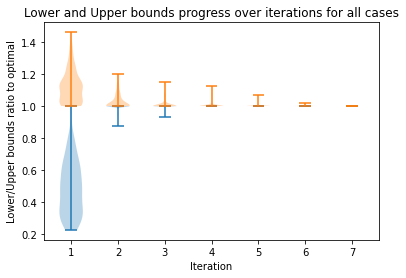

In [19]:
plotBounds(df) 

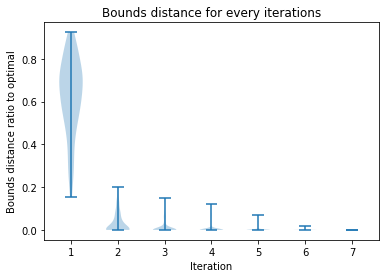

In [20]:
def plotBoundsDistances(df) :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.BoundsDistances.to_list(), columns=range(sdf.IterationCount.max())))
    _ = plt.title("Bounds distance for every iterations")
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Bounds distance ratio to optimal")
plotBoundsDistances(df)

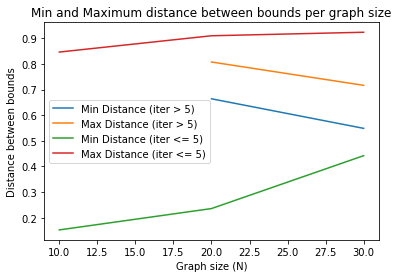

In [21]:
def plotMinMaxBoundDistance (df, label1 = "Minimal distance", label2 = "Maximal distance") :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    sdf["BoundsDistancesMax"] = sdf.BoundsDistances.apply(lambda x : max(x))

    x = sdf.groupby("n").max().reset_index()["n"]
    y1 = sdf.groupby("n").min().reset_index()["BoundsDistancesMax"]
    y2 = sdf.groupby("n").max().reset_index()["BoundsDistancesMax"]

    _ = plt.plot(x,y1,  label = label1)
    _ = plt.plot(x,y2,  label = label2)
    _ = plt.title("Min and Maximum distance between bounds per graph size")
    _ = plt.xlabel("Graph size (N)")
    _ = plt.ylabel("Distance between bounds")
    _ = plt.legend()
plotMinMaxBoundDistance(df[df.IterationCount > 5], label1="Min Distance (iter > 5)", label2="Max Distance (iter > 5)")
plotMinMaxBoundDistance(df[df.IterationCount <= 5], label1="Min Distance (iter <= 5)", label2="Max Distance (iter <= 5)")

In [22]:

import seaborn as sns
    

    
def plotDataFrame(_df, header="Untitled") :
    fig, axes = plt.subplots(3,2,figsize=(10,10))
    fig.suptitle(f'Summary from {header}')
    plt.sca(axes[0,0])
    plotBounds(_df)
    plt.sca(axes[1,0])
    plotBoundsDistances(_df)
    plt.sca(axes[0,1])
    lower_upper_detailled(_df)
    plt.sca(axes[1,1])
    plotMinMaxBoundDistance(_df)
    plt.sca(axes[2,0])
    df["bounds_shift"].hist()
    plt.tight_layout()
    summarizePlots(_df)
    _ = df[[ "n","m",  "sum_n", "IterationCount"]].hist()
    
def plotDataFile(filename) :
    _df = openLog(filename)
    plotDataFrame(_df, filename)
   

# Most recent changes

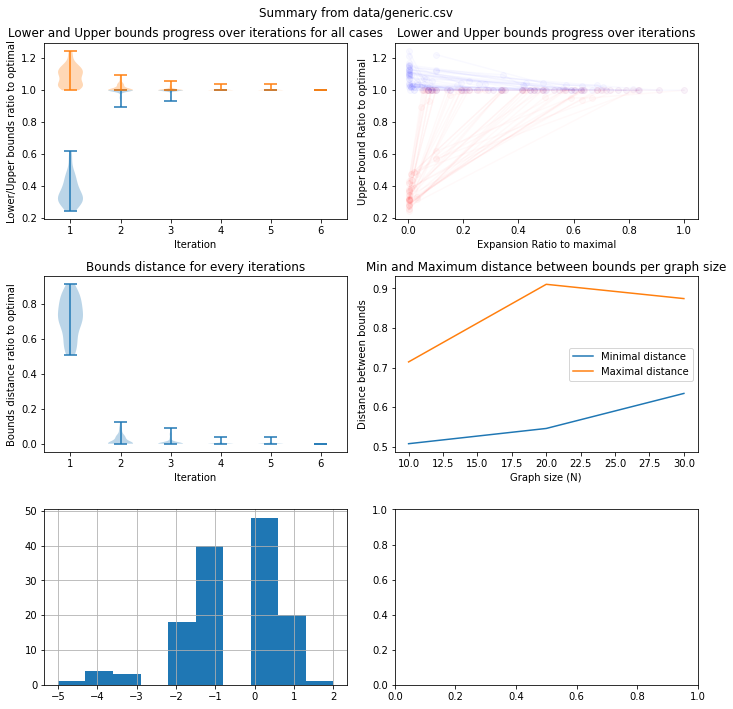

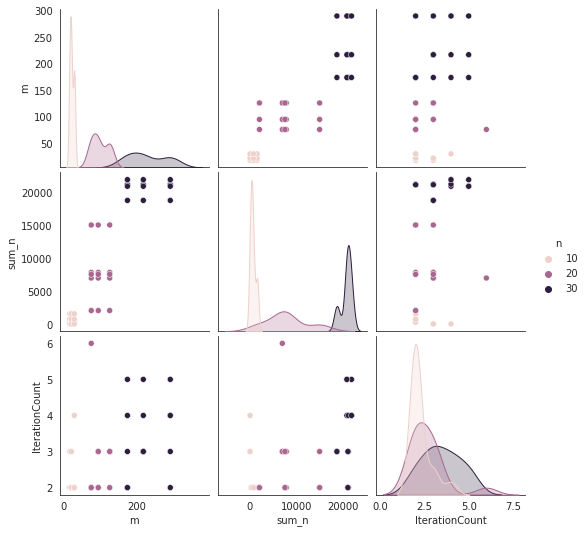

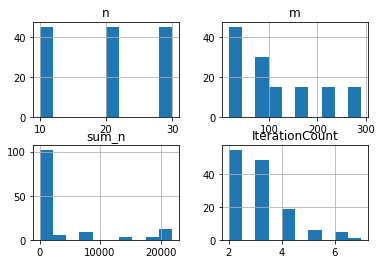

In [23]:
plotDataFile("data/generic.csv")

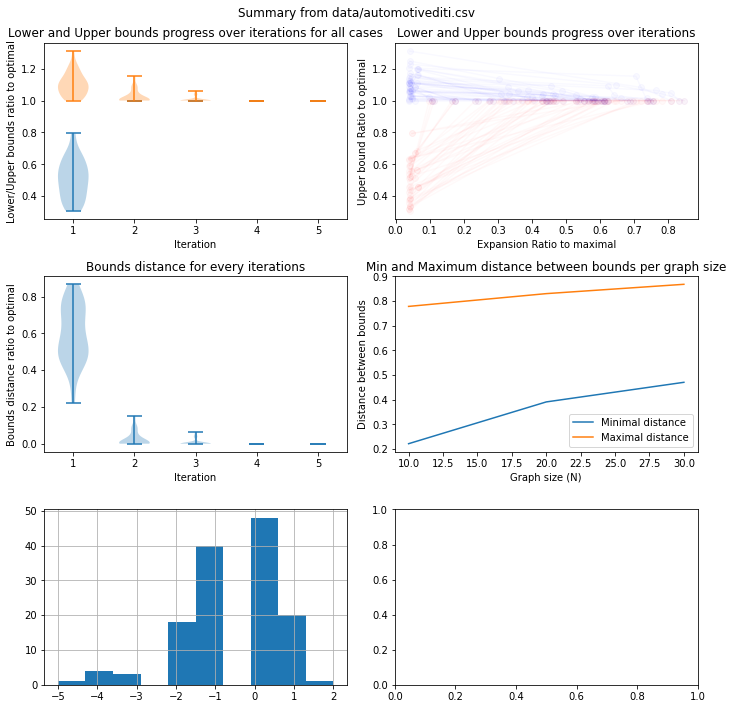

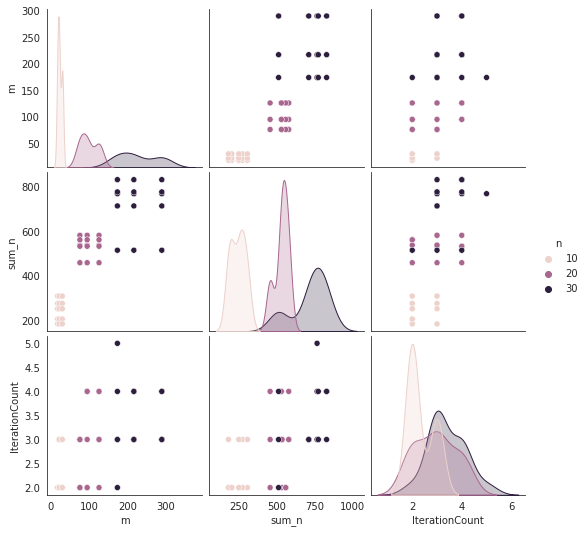

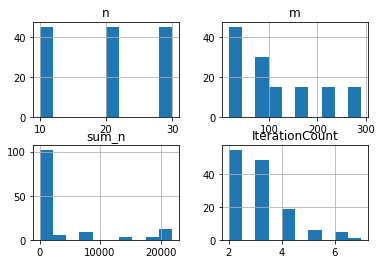

In [24]:
plotDataFile("data/automotivediti.csv")

# Strange behaviour for generic

In [25]:
generic_df = openLog("data/containsAnomalies.csv")
generic_df = generic_df[generic_df["bounds_shift"].isna()]
generic_df = generic_df[generic_df["sum_n"] < 50]
generic_df

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,UpperBounds,gen_time,lbp_time,ubp_time,total_time,BoundsDistances,bounds_shift,early_bounds,filename,remain_time
13366,13366,3493,generic,0,4,3,15,15,2,"[0.35294117647058826, 0.9411764705882353]",...,"[1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.33333333333333337, 0.2666666666666667]",NaN,None,data/containsAnomalies.csv,0.0
18161,18161,8288,generic,0,4,3,41,14,3,"[0.13953488372093023, 0.23255813953488372, 0.4...",...,"[1.2142857142857142, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.6428571428571428, 0.0714285714285714, 0.142...",NaN,None,data/containsAnomalies.csv,1.0
23366,23366,3493,generic,0,4,4,15,15,2,"[0.35294117647058826, 0.9411764705882353]",...,"[1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.33333333333333337, 0.2666666666666667]",NaN,None,data/containsAnomalies.csv,0.0
28492,28492,8619,generic,0,4,4,22,16,2,"[0.25, 0.9166666666666666]",...,"[1.125, 1.0]",0.0,0.0,0.0,0.0,"[0.4375, 0.0625]",NaN,None,data/containsAnomalies.csv,0.0
46681,46681,6809,generic,0,5,5,40,18,2,"[0.16666666666666666, 0.9523809523809523]",...,"[1.1111111111111112, 1.0]",0.0,0.0,0.0,1.0,"[0.38888888888888895, 0.05555555555555558]",NaN,None,data/containsAnomalies.csv,1.0
56681,56681,6809,generic,0,5,6,40,18,2,"[0.16666666666666666, 0.9523809523809523]",...,"[1.1111111111111112, 1.0]",0.0,0.0,0.0,1.0,"[0.38888888888888895, 0.05555555555555558]",NaN,None,data/containsAnomalies.csv,1.0


In [26]:
generic_df = openLog("data/containsAnomalies_diti.csv")
generic_df[generic_df["bounds_shift"].isna()]

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,UpperBounds,gen_time,lbp_time,ubp_time,total_time,BoundsDistances,bounds_shift,early_bounds,filename,remain_time
14178,14178,4305,generic,1,4,3,104,22,3,"[0.05660377358490566, 0.19811320754716982, 0.4...",...,"[1.0909090909090908, 1.0, 1.0]",0.0,0.0,0.0,2.0,"[0.4545454545454545, 0.045454545454545414, 0.3...",NaN,None,data/containsAnomalies_diti.csv,2.0
17802,17802,7929,generic,1,4,3,103,28,3,"[0.05714285714285714, 0.19047619047619047, 0.4...",...,"[1.1785714285714286, 1.0, 1.0]",0.0,0.0,0.0,2.0,"[0.5, 0.1071428571428571, 0.25]",NaN,None,data/containsAnomalies_diti.csv,2.0
20199,20199,326,generic,1,4,4,201,26,3,"[0.029556650246305417, 0.12807881773399016, 0....",...,"[1.0769230769230769, 1.0, 1.0]",1.0,3.0,1.0,7.0,"[0.423076923076923, 0.038461538461538436, 0.5]",NaN,None,data/containsAnomalies_diti.csv,2.0
20900,20900,1027,generic,1,4,4,94,22,3,"[0.0625, 0.20833333333333334, 0.4791666666666667]",...,"[1.0454545454545454, 1.0, 1.0]",0.0,0.0,0.0,2.0,"[0.4545454545454545, 0.045454545454545414, 0.1...",NaN,None,data/containsAnomalies_diti.csv,2.0
21272,21272,1399,generic,1,4,4,248,22,3,"[0.024, 0.128, 0.28]",...,"[1.0454545454545454, 1.0, 1.0]",0.0,1.0,1.0,4.0,"[0.6363636363636362, 0.045454545454545414, 0.5...",NaN,None,data/containsAnomalies_diti.csv,2.0
23569,23569,3696,generic,1,4,4,23,37,3,"[0.24, 0.88, 0.92]",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.21621621621621623, 0.05405405405405406, 0.0...",NaN,None,data/containsAnomalies_diti.csv,1.0
26508,26508,6635,generic,1,4,4,173,26,3,"[0.03428571428571429, 0.18285714285714286, 0.36]",...,"[1.0769230769230769, 1.0, 1.0]",0.0,1.0,0.0,3.0,"[0.3846153846153846, 0.038461538461538436, 0.4...",NaN,None,data/containsAnomalies_diti.csv,2.0
28207,28207,8334,generic,1,4,4,241,28,3,"[0.024691358024691357, 0.18106995884773663, 0....",...,"[1.0357142857142858, 1.0, 1.0]",0.0,1.0,0.0,5.0,"[0.3571428571428572, 0.0357142857142857, 0.535...",NaN,None,data/containsAnomalies_diti.csv,4.0
31566,31566,1694,generic,1,5,4,391,21,3,"[0.017811704834605598, 0.027989821882951654, 0...",...,"[1.0476190476190477, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.4285714285714286, 0.04761904761904767, 0.19...",NaN,None,data/containsAnomalies_diti.csv,1.0
32898,32898,3026,generic,1,5,4,454,35,3,"[0.015350877192982455, 0.07675438596491228, 0....",...,"[1.0571428571428572, 1.0, 1.0]",2.0,6.0,2.0,14.0,"[0.4285714285714286, 0.02857142857142858, 0.48...",NaN,None,data/containsAnomalies_diti.csv,4.0


In [27]:
dfbak = openLogs(["data/containsAnomalies.csv", "data/containsAnomalies_diti.csv"])

In [28]:
# Pathological case Lowe doe not finish
# Simple cases (low sum_n)
# Interesting cases (iteration count = 2)
df = dfbak.copy()

#df = df[df["bounds_shift"].isna()]
df = df[df["sum_n"] <= 50]

df[df.apply(lambda x : x.LowerBounds != sorted(x.LowerBounds), axis = 1)]

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,UpperBounds,gen_time,lbp_time,ubp_time,total_time,BoundsDistances,bounds_shift,early_bounds,filename,remain_time
667,667,794,generic,0,4,2,48,10,3,"[0.12, 0.16, 0.54]",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.4, 0.0, 0.6]",1.0,True,data/containsAnomalies.csv,1.0
2481,2481,2608,generic,0,4,2,26,7,3,"[0.21428571428571427, 0.42857142857142855, 0.6...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.2857142857142857, 0.0, 0.2857142857142857]",1.0,True,data/containsAnomalies.csv,1.0
3757,3757,3884,generic,0,4,2,41,6,3,"[0.13953488372093023, 0.20930232558139536, 0.3...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.33333333333333337, 0.0, 0.5]",1.0,True,data/containsAnomalies.csv,0.0
13601,13601,3728,generic,0,4,3,47,13,3,"[0.12244897959183673, 0.3469387755102041, 0.48...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.23076923076923073, 0.0, 0.23076923076923073]",1.0,True,data/containsAnomalies.csv,1.0
18161,18161,8288,generic,0,4,3,41,14,3,"[0.13953488372093023, 0.23255813953488372, 0.4...",...,"[1.2142857142857142, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.6428571428571428, 0.0714285714285714, 0.142...",NaN,None,data/containsAnomalies.csv,1.0
18689,18689,8816,generic,0,4,3,29,12,3,"[0.1935483870967742, 0.3870967741935484, 0.774...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.41666666666666663, 0.0, 0.25]",1.0,True,data/containsAnomalies.csv,1.0
20425,20425,552,generic,0,4,4,21,13,3,"[0.2608695652173913, 0.391304347826087, 0.5217...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.3076923076923077, 0.0, 0.5384615384615384]",1.0,True,data/containsAnomalies.csv,0.0
20595,20595,722,generic,0,4,4,31,15,3,"[0.18181818181818182, 0.24242424242424243, 0.6...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.4, 0.0, 0.4]",1.0,True,data/containsAnomalies.csv,1.0
23284,23284,3411,generic,0,4,4,17,8,3,"[0.3157894736842105, 0.42105263157894735, 0.63...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.5, 0.0, 0.625]",1.0,True,data/containsAnomalies.csv,0.0
23899,23899,4026,generic,0,4,4,19,7,3,"[0.2857142857142857, 0.42857142857142855, 0.61...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.2857142857142857, 0.0, 0.4285714285714286]",1.0,True,data/containsAnomalies.csv,0.0


In [29]:
dfbak = openLog("data/containsAnomalies.csv")


In [30]:
# Pathological case Lowe doe not finish
# Simple cases (low sum_n)
# Interesting cases (iteration count = 2)
df = dfbak.copy()

df = df[df["bounds_shift"].isna()]
df = df[df["sum_n"] <= 50]
df

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,UpperBounds,gen_time,lbp_time,ubp_time,total_time,BoundsDistances,bounds_shift,early_bounds,filename,remain_time
13366,13366,3493,generic,0,4,3,15,15,2,"[0.35294117647058826, 0.9411764705882353]",...,"[1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.33333333333333337, 0.2666666666666667]",NaN,None,data/containsAnomalies.csv,0.0
18161,18161,8288,generic,0,4,3,41,14,3,"[0.13953488372093023, 0.23255813953488372, 0.4...",...,"[1.2142857142857142, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.6428571428571428, 0.0714285714285714, 0.142...",NaN,None,data/containsAnomalies.csv,1.0
23366,23366,3493,generic,0,4,4,15,15,2,"[0.35294117647058826, 0.9411764705882353]",...,"[1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.33333333333333337, 0.2666666666666667]",NaN,None,data/containsAnomalies.csv,0.0
28492,28492,8619,generic,0,4,4,22,16,2,"[0.25, 0.9166666666666666]",...,"[1.125, 1.0]",0.0,0.0,0.0,0.0,"[0.4375, 0.0625]",NaN,None,data/containsAnomalies.csv,0.0
46681,46681,6809,generic,0,5,5,40,18,2,"[0.16666666666666666, 0.9523809523809523]",...,"[1.1111111111111112, 1.0]",0.0,0.0,0.0,1.0,"[0.38888888888888895, 0.05555555555555558]",NaN,None,data/containsAnomalies.csv,1.0
56681,56681,6809,generic,0,5,6,40,18,2,"[0.16666666666666666, 0.9523809523809523]",...,"[1.1111111111111112, 1.0]",0.0,0.0,0.0,1.0,"[0.38888888888888895, 0.05555555555555558]",NaN,None,data/containsAnomalies.csv,1.0


In [31]:
dfbak = openLog("data/seek3.csv")

<AxesSubplot:>

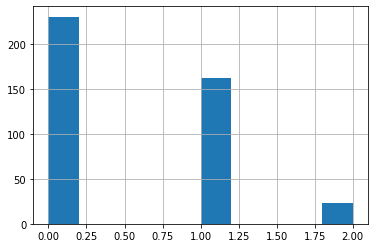

In [32]:
# Simple cases (low sum_n)
# Interesting cases (iteration count = 3)
df = dfbak.copy()
df = df[df["sum_n"] <= 50]
df = df[df["IterationCount"] == 3]
df.apply(lambda x : x["UpperBounds"].index(1.0), axis = 1).hist()

<AxesSubplot:>

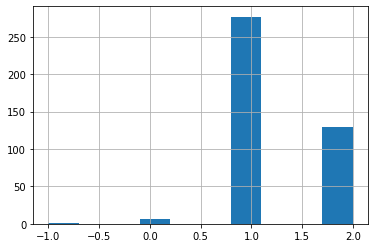

In [33]:
df.apply(lambda x : x["LowerBounds"].index(1.0) if x["LowerBounds"].count(1.0) else -1, axis = 1).hist()

<AxesSubplot:>

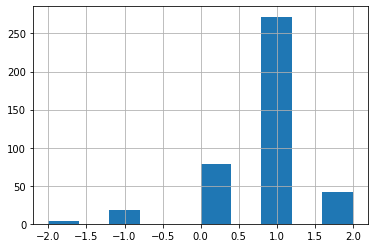

In [34]:
# Good cases for lower bound (lower bound reach optimum)
df = df[df.apply(lambda x :  x["LowerBounds"].count(1.0) >= 1, axis = 1)]
df["bounds_shift"].hist()

In [35]:
df = df[df["n"] > 3]
df = df[df["m"] >= 3]
df

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,UpperBounds,gen_time,lbp_time,ubp_time,total_time,BoundsDistances,bounds_shift,early_bounds,filename,remain_time
40307,40307,434,generic,0,4,3,31,15,3,"[0.18181818181818182, 0.48484848484848486, 0.6...",...,"[1.0666666666666667, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.4, 0.1333333333333333, 0.0]",1.0,False,data/seek3.csv,1.0
40484,40484,611,generic,0,4,3,49,20,3,"[0.11764705882352941, 0.4117647058823529, 0.54...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.4, 0.0, 0.0]",1.0,True,data/seek3.csv,1.0
40518,40518,645,generic,0,4,3,15,9,3,"[0.35294117647058826, 0.6470588235294118, 0.82...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.5555555555555556, 0.0, 0.0]",1.0,True,data/seek3.csv,0.0
40529,40529,656,generic,0,4,3,35,12,3,"[0.16216216216216217, 0.2972972972972973, 0.91...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.5, 0.08333333333333337, 0.0]",2.0,False,data/seek3.csv,1.0
40642,40642,769,generic,0,4,3,43,16,3,"[0.13333333333333333, 0.35555555555555557, 1.0]",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,2.0,"[0.8125, 0.125, 0.0]",2.0,False,data/seek3.csv,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89360,89360,9488,generic,0,5,6,25,11,3,"[0.25925925925925924, 0.8148148148148148, 0.85...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,1.0,"[0.5454545454545454, 0.0, 0.0]",1.0,True,data/seek3.csv,1.0
89647,89647,9775,generic,0,5,6,16,12,3,"[0.3888888888888889, 0.7222222222222222, 0.777...",...,"[1.0, 1.0, 1.0]",0.0,0.0,0.0,0.0,"[0.41666666666666663, 0.0, 0.0]",1.0,True,data/seek3.csv,0.0
89831,89831,9959,generic,0,5,6,41,21,3,"[0.16279069767441862, 0.7906976744186046, 1.0]",...,"[1.1904761904761905, 1.1428571428571428, 1.0]",0.0,0.0,0.0,2.0,"[0.7619047619047619, 0.1428571428571428, 0.0]",-1.0,False,data/seek3.csv,2.0
89842,89842,9970,generic,0,5,6,37,14,3,"[0.1794871794871795, 0.3076923076923077, 0.846...",...,"[1.0714285714285714, 1.0714285714285714, 1.0]",0.0,0.0,0.0,1.0,"[0.3571428571428571, 0.0714285714285714, 0.0]",-1.0,False,data/seek3.csv,1.0


# Drawing User cases

In [36]:
!mkdir figures -p
!rm figures/*

In [37]:
class Instance :
    def __init__ (self, n,m,seed,kind, DiEqTi) :
        self.n   = n
        self.m   = m
        self.kind   = kind
        self.seed   = seed
        self.DiEqTi = DiEqTi
        
    def __str__ (self) :
        return f"Instance ({self.n}, {self.m}, {self.seed}, {self.kind}, {self.DiEqTi})"
    def __repr__ (self) :
        return self.__str__()

def getLET(inst): 
    import os 
    import subprocess
    import sys
    from IPython import display
    valid_kinds = ["generic", "automotive", "harmonic"]
    n  = inst.n
    m = inst.m
    seed = inst.seed
    kind = inst.kind
    DiEqTi = inst.DiEqTi
    
    if kind == 1 : kind = "generic"
    if not kind in valid_kinds :
        print (f"invalid kind '{kind}'")
    assert( kind in valid_kinds )
        
    cmd = ["../build/src/lig-analyse", "-n", str(n), "-m", str(m), "-seed", str(seed), "-kind", kind, "-outputsvg"]
    if DiEqTi :
        cmd .append("-DiEqualTi")
    sys.stderr.write(f" " + " ".join(cmd))
    
    proc = subprocess.Popen([str(x) for x in cmd], stdout=subprocess.PIPE)
    out,err = proc.communicate()
    return display.SVG(out)

def getPEG(inst, upper=None, lower=None): 
    import os 
    import subprocess
    import sys
    from IPython import display
    assert (upper == None or lower==None) # Need only on of them
    
    n  = inst.n
    m = inst.m
    seed = inst.seed
    kind = inst.kind
    DiEqTi = inst.DiEqTi
    
    if kind == 1 : kind = "generic"
        
    cmd = ["../build/src/lig-analyse", "-n", str(n), "-m", str(m), "-seed", str(seed), "-kind", kind, "-outputsvg", "-agelatency"]
    if DiEqTi :
        cmd .append("-DiEqualTi")
    sys.stderr.write(f" " + " ".join(cmd))
    proc = subprocess.Popen([str(x) for x in cmd], stdout=subprocess.PIPE)
    out,err = proc.communicate()
    required = ""
    res = ""
    if upper :
        required = f"// Upper bound with K=[{','.join([str(x) for x in upper])}]"
    if lower :
        required = f"// Lower bound with K=[{','.join([str(x) for x in lower])}]"
    print (f"<!-- {required} -->")
    for line in out.decode("utf-8").split("\n"):
        if line[:2] == "//":
            current = line
            if required == "" :
                print (line)
        elif current == required :
            res += (line)
    return display.SVG(res)

def saveSVGIntoPNG(obj, filename):
    from cairosvg import svg2png
    svg2png(bytestring=obj.data,write_to=filename)
        
def saveInto(obj, filename):
    with open(filename, 'w') as fdesc:
        fdesc.write(obj)
        

# Use-case 1: When Lower bound reach optimality first

This example shows a situation where lower bound can help to interupt computation earlier.

 ../build/src/lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg

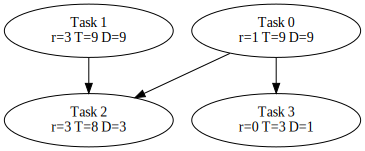

In [38]:
uc1 = Instance(4,3,611,"generic", False)
g = getLET(uc1)
saveSVGIntoPNG(g, "figures/usecase1.png")
g

This is a very simple example with 4 tasks and 3 edges. 
The very first partial expansion is using K=1,1,1,1:

<!-- // Upper bound with K=[1,1,1,1] -->


 ../build/src/lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -agelatency

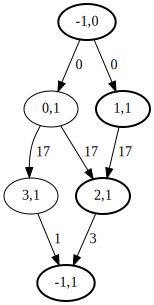

In [39]:
g = getPEG(uc1, upper=[1,1,1,1])
saveSVGIntoPNG(g, "figures/uc1_u1111.png")
g

 ../build/src/lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -agelatency

<!-- // Lower bound with K=[1,1,1,1] -->


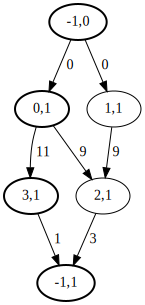

In [40]:
g = getPEG(uc1, lower=[1,1,1,1])
saveSVGIntoPNG(g, "figures/uc1_l1111.png")
g

Uppuer bound for the Age Latency is 20, meanwhile the lower bound is 12.
From there we naturally increase the values of K = 1,8,9,1. 

 ../build/src/lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -agelatency

<!-- // Upper bound with K=[1,8,9,1] -->


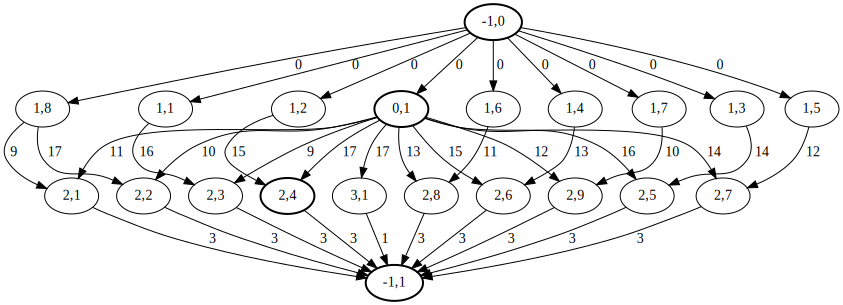

In [41]:
g = getPEG(uc1, upper=[1,8,9,1])
saveSVGIntoPNG(g, "figures/uc1_u1891.png")
g

 ../build/src/lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -agelatency

<!-- // Lower bound with K=[1,8,9,1] -->


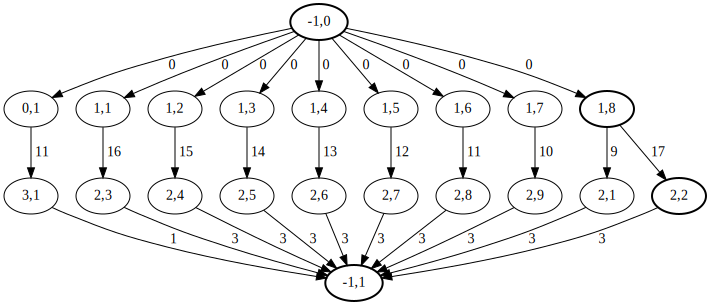

In [42]:
g = getPEG(uc1, lower=[1,8,9,1])
saveSVGIntoPNG(g, "figures/uc1_l1891.png")
g

Once again the upper bounds reach 20 for the age latency. Interestingly, this time the lower bound is also of 20. This garantie we reached optimality the algotihm terminates.

On the contrary, if we did not use the lower bound, we would require to interate another time in order to confirm this result with K=[8,8,9,1]. And only then we could have confirmed we reach optimality. 

# Use-case 2: When lower bound does not reach optimality

It is very interesting to note the existence of instances where, considering Algoritm 1, the lower bound will not be able to reach optimality. 
These very rare cases are possible, and force us to verify the original condition from Ning in addition of comparing lower and upper bound. 

The following example is one of these cases.

 ../build/src/lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg

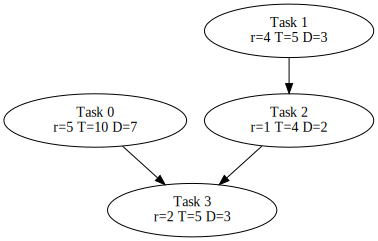

In [43]:
uc2 = Instance(4,3, 3493, "generic", False)
g = getLET(uc2)
saveSVGIntoPNG(g, "figures/usecase2.png")
g

First iteration, we identify a critical path, and update K accordingly.
Second iteration, we found a new path, however updating K does not chage its values. We reach the optimum. meanwhile, with the same exact value of K, the lower bound does not reach the optimum. 

 ../build/src/lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg -agelatency

<!-- // Upper bound with K=[1,1,1,1] -->


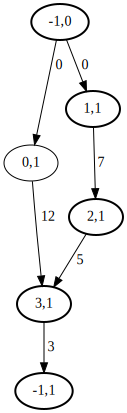

In [44]:
g = getPEG(uc2, upper=[1,1,1,1])
saveSVGIntoPNG(g, "figures/uc2_u1111.png")
g

<!-- // Upper bound with K=[1,4,5,4] -->


 ../build/src/lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg -agelatency

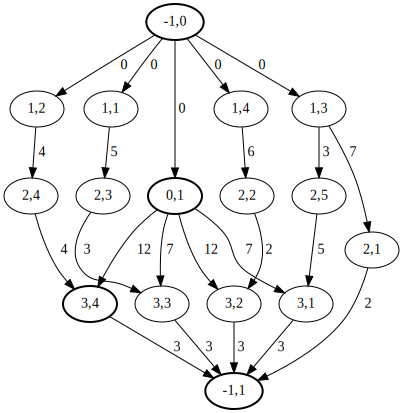

In [45]:
g = getPEG(uc2, upper=[1,4,5,4])
saveSVGIntoPNG(g, "figures/uc2_u1454.png")
g

 ../build/src/lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg -agelatency

<!-- // Lower bound with K=[1,4,5,4] -->


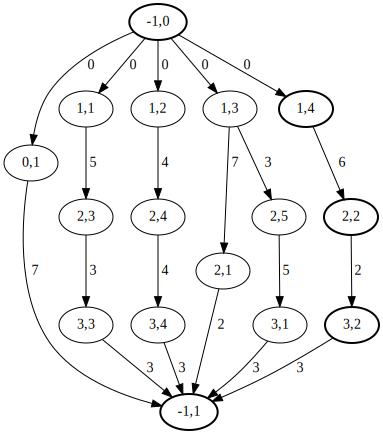

In [46]:
g = getPEG(uc2, lower=[1,4,5,4])
saveSVGIntoPNG(g, "figures/uc2_l1454.png")
g

# User-case 3: When lower bound decrease while K increase. 

Since Bodin2016, it is accepted that increasing the values of K arbitrarily does not necessarily improve estiation results.
However a dominant subset has been identified and consistantly improve the upper bound. 
Meanwhile we found example where an update of K can degrade the lower bound despite improving the upper bound.

In this example, the upper bound ciritical path for K=1,1,1,1 indicate a new vector K=[8,3,24,1,3]. This new vector K reach optimality.
However, the same update of K for the lower bound has the oposite effect that while lower bound was 19 initially, it went down to 12 after this update of K.



 ../build/src/lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg

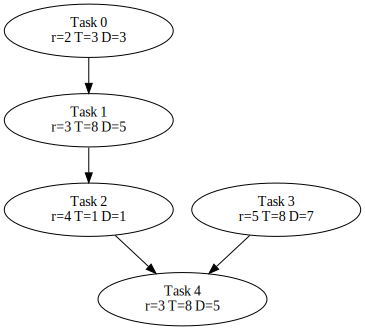

In [47]:
uc3 = Instance(5,4,2070,"generic", False)
g = getLET(uc3)
saveSVGIntoPNG(g, "figures/usecase3.png")
g

 ../build/src/lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg -agelatency

<!-- // Upper bound with K=[1,1,1,1,1] -->


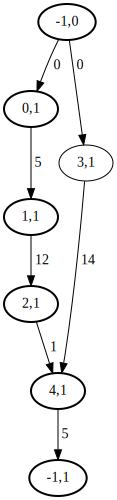

In [48]:
g = getPEG(uc3, upper = [1,1,1,1,1])
saveSVGIntoPNG(g, "figures/uc3_u11111.png")
g

 ../build/src/lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg -agelatency

<!-- // Lower bound with K=[1,1,1,1,1] -->


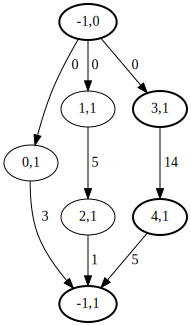

In [49]:
g = getPEG(uc3, lower = [1,1,1,1,1])
saveSVGIntoPNG(g, "figures/uc3_l11111.png")
g

 ../build/src/lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg -agelatency

<!-- // Lower bound with K=[8,3,24,1,3] -->


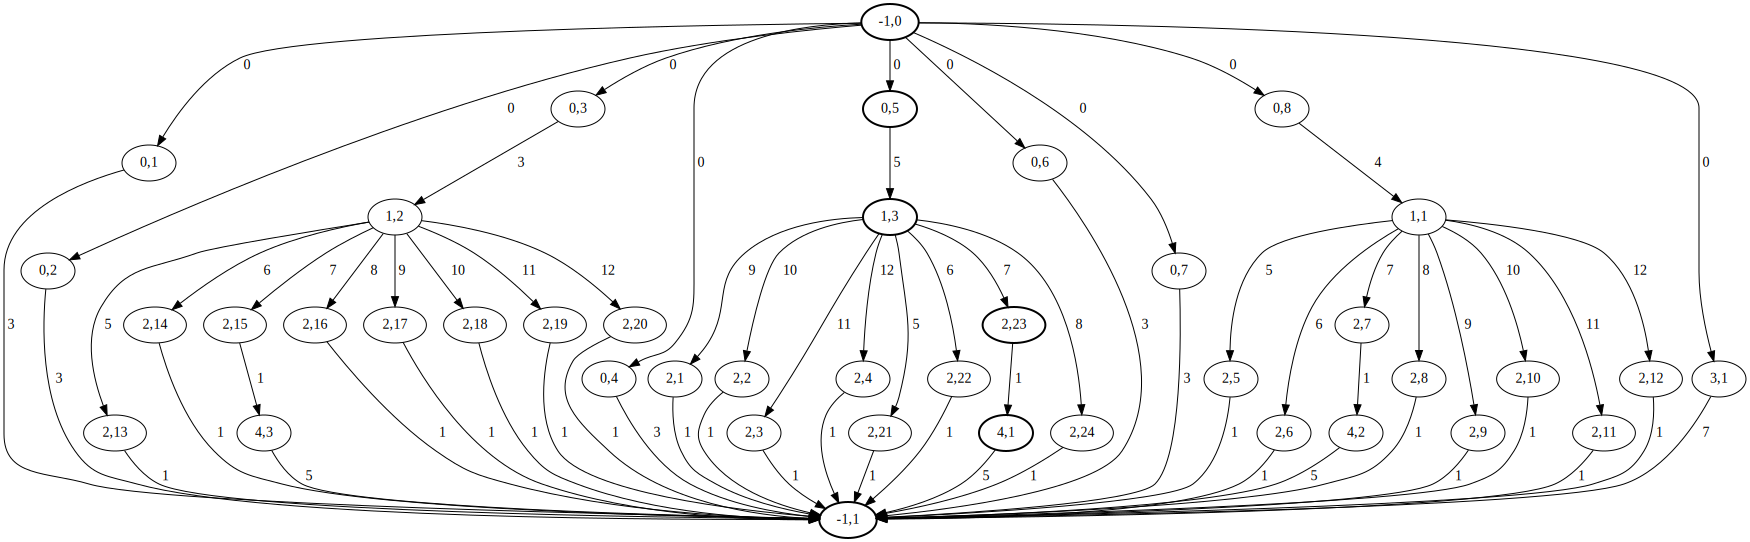

In [50]:
g = getPEG(uc3, lower=[8,3,24,1,3])
saveSVGIntoPNG(g, "figures/uc3_l832413.png")
g

# Looking for example

In [51]:
fdf = openLogs([ "data/automotivediti.csv","data/harmonic.csv","data/harmonicditi.csv", "data/containsAnomalies.csv", "data/generic.csv", "data/containsAnomalies_diti.csv"])

In [52]:
demo = fdf
demo = demo[demo["IterationCount"] == 3]
demo = demo[demo["n"] == 4]
demo = demo[demo["bounds_shift"] == -1]
demo = demo[demo.apply(lambda x : x["ExpansionVertex"][-1] != 1, axis = 1)]
demo = demo[demo.apply(lambda x : x["BoundsDistances"][-1] == 0, axis = 1)]
demo = demo[demo.apply(lambda x : x["BoundsDistances"][-2] != 0, axis = 1)]
demo = demo.sort_values(["sum_n"])
demo

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,UpperBounds,gen_time,lbp_time,ubp_time,total_time,BoundsDistances,bounds_shift,early_bounds,filename,remain_time
85883,25703,5830,generic,1,4,4,19,28,3,"[0.2857142857142857, 0.5714285714285714, 0.761...",...,"[1.2857142857142858, 1.0714285714285714, 1.0]",0.0,0.0,0.0,0.0,"[0.7500000000000001, 0.0714285714285714, 0.0]",-1.0,False,data/containsAnomalies_diti.csv,0.0
29668,29533,9660,generic,0,4,4,31,16,3,"[0.18181818181818182, 0.5757575757575758, 0.69...",...,"[1.3125, 1.0625, 1.0]",0.0,0.0,0.0,1.0,"[0.875, 0.0625, 0.0]",-1.0,False,data/containsAnomalies.csv,1.0
29399,29264,9391,generic,0,4,4,43,21,3,"[0.13333333333333333, 0.6222222222222222, 0.8]",...,"[1.1428571428571428, 1.0952380952380953, 1.0]",0.0,0.0,0.0,2.0,"[0.7142857142857142, 0.09523809523809534, 0.0]",-1.0,False,data/containsAnomalies.csv,2.0


In [53]:
instances = demo.apply(lambda x : Instance(x.n,x.m,x.seed,x.kind, x.DiEqTi), axis = 1).tolist()
instances

[Instance (4, 4, 5830, generic, 1),
 Instance (4, 4, 9660, generic, 0),
 Instance (4, 4, 9391, generic, 0)]

 ../build/src/lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputsvg

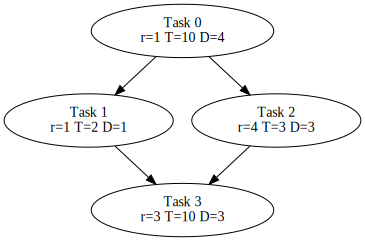

In [54]:
 getLET(instances[1])

In [55]:
example = Instance (4, 4, 9660, 1, 0)

 ../build/src/lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputsvg

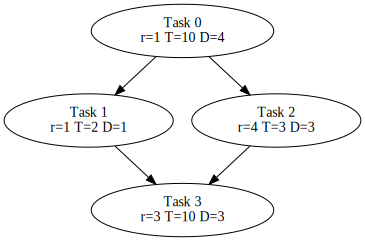

In [56]:
g = getLET(example)
saveSVGIntoPNG(g, "figures/example.png")
g

<!-- // Upper bound with K=[1,1,1,1] -->


 ../build/src/lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputsvg -agelatency

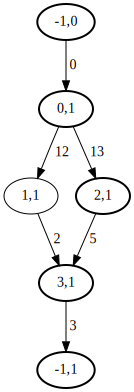

In [57]:
g = getPEG(example, upper=[1,1,1,1])
saveSVGIntoPNG(g, "figures/example_u1111.png")
g

In [58]:
def getSchedule(inst, duration): 
    import os 
    import subprocess
    import sys
    from IPython import display
    n  = inst.n
    m = inst.m
    seed = inst.seed
    kind = inst.kind
    DiEqTi = inst.DiEqTi
    
    if kind == 1 : kind = "generic"
    cmd = ["../build/src/lig-analyse", "-n", str(n), "-m", str(m), "-seed", str(seed), "-kind", kind, "-outputtikz","-schedule_duration", str(duration)]
    if DiEqTi :
        cmd .append("-DiEqualTi")
    sys.stderr.write(f" " + " ".join(cmd))
    
    proc = subprocess.Popen([str(x) for x in cmd], stdout=subprocess.PIPE)
    out,err = proc.communicate()
    return out.decode("utf-8")

In [59]:
schedule = getSchedule(example, 150)
print(schedule)
saveInto(schedule,"figures/example_schedule.tikz")


\begin{tikzpicture}[transform shape,scale=0.5]
\LETSchedule{4}{150}
\LETTask{0}{1}{4}{4}{10}
\LETTask{1}{1}{1}{1}{2}
\LETTask{2}{4}{3}{3}{3}
\LETTask{3}{3}{3}{3}{10}
\LETExecutionDependency{1}{1}{3}{1}
\LETExecutionDependency{1}{6}{3}{2}
\LETExecutionDependency{1}{11}{3}{3}
\LETExecutionDependency{1}{16}{3}{4}
\LETExecutionDependency{1}{21}{3}{5}
\LETExecutionDependency{1}{26}{3}{6}
\LETExecutionDependency{1}{31}{3}{7}
\LETExecutionDependency{1}{36}{3}{8}
\LETExecutionDependency{1}{41}{3}{9}
\LETExecutionDependency{1}{46}{3}{10}
\LETExecutionDependency{1}{51}{3}{11}
\LETExecutionDependency{1}{56}{3}{12}
\LETExecutionDependency{1}{61}{3}{13}
\LETExecutionDependency{1}{66}{3}{14}
\LETExecutionDependency{0}{1}{1}{3}
\LETExecutionDependency{0}{1}{1}{4}
\LETExecutionDependency{0}{1}{1}{5}
\LETExecutionDependency{0}{1}{1}{6}
\LETExecutionDependency{0}{1}{1}{7}
\LETExecutionDependency{0}{2}{1}{8}
\LETExecutionDependency{0}{2}{1}{9}
\LETExecutionDependency{0}{2}{1}{10}
\LETExecutionDependency

 ../build/src/lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputtikz -schedule_duration 150

# Generating timing analysis

<AxesSubplot:xlabel='n'>

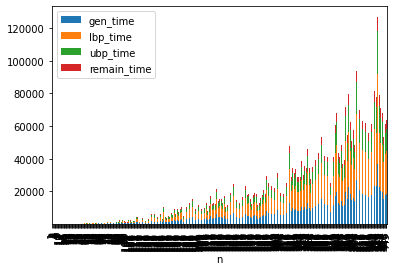

In [168]:
df = openLogs(["../automotive.paper.csv"])
df.groupby("n").mean().plot(kind='bar',y=["gen_time", "lbp_time", "ubp_time", 'remain_time'], stacked=True)

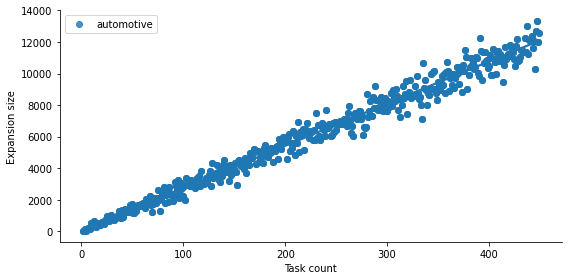

In [169]:
g = sns.lmplot(x="n", y="sum_n", hue="kind", data=df, legend=False, height=4, aspect= 2)
g = g.set_axis_labels("Task count", "Expansion size")
_ = g.ax.legend(loc=2)
plt.savefig("figures/dataset_size.pdf")

<AxesSubplot:xlabel='n'>

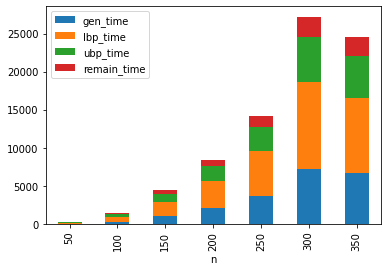

In [162]:
df = openLogs(["data/automotive.large.csv"])
df.groupby("n").mean().plot(kind='bar',y=["gen_time", "lbp_time", "ubp_time", 'remain_time'], stacked=True)

<AxesSubplot:xlabel='n'>

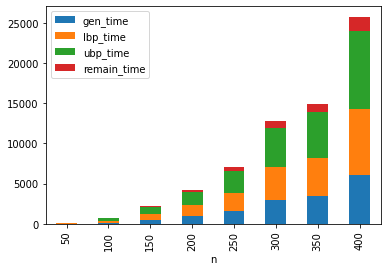

In [171]:
df = openLogs(["../automotive.new3.csv"])
df.groupby("n").mean().plot(kind='bar',y=["gen_time", "lbp_time", "ubp_time", 'remain_time'], stacked=True)

<AxesSubplot:xlabel='n'>

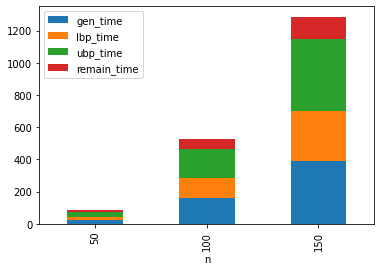

In [170]:
df = openLogs(["../automotive.new4.csv"])
df.groupby("n").mean().plot(kind='bar',y=["gen_time", "lbp_time", "ubp_time", 'remain_time'], stacked=True)

In [161]:
df = openLogs(["data/automotive.csv", "data/harmonic.csv", "data/generic.csv"])

In [63]:
dataset_df = df[["kind", "n", "m", "sum_n"]]

In [64]:
dataset_df.groupby(["n", "kind"]).mean().transpose()

n              10                                20                   \
kind   automotive     generic   harmonic automotive generic harmonic   
m       23.333333   23.333333  23.333333       99.0    99.0     99.0   
sum_n  368.000000  698.200000  88.400000      567.2  7943.6    913.2   

n             30                    
kind  automotive  generic harmonic  
m          227.0    227.0    227.0  
sum_n      743.8  20779.8   1558.4

<AxesSubplot:>

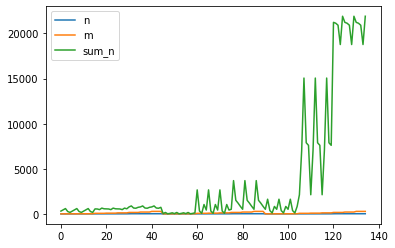

In [65]:
dataset_df.plot()

<AxesSubplot:xlabel='n'>

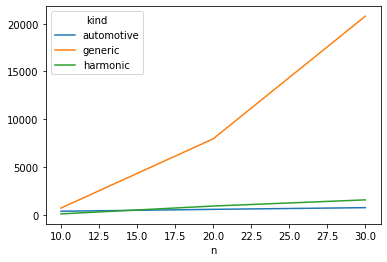

In [70]:
dataset_df.groupby(["n", "kind"]).mean()["sum_n"].unstack(level=-1).plot()

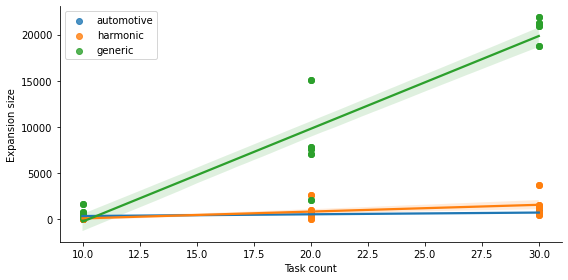

In [103]:
g = sns.lmplot(x="n", y="sum_n", hue="kind", data=dataset_df, legend=False, height=4, aspect= 2)
g = g.set_axis_labels("Task count", "Expansion size")
_ = g.ax.legend(loc=2)
plt.savefig("figures/dataset_size.pdf")

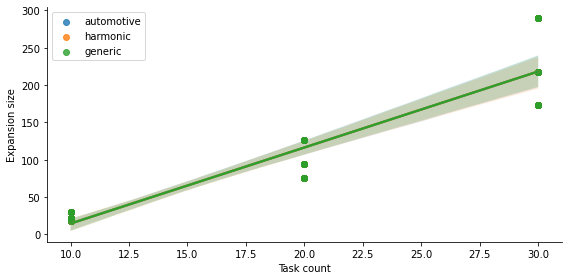

In [104]:
g = sns.lmplot(x="n", y="m", hue="kind", data=dataset_df, legend=False, height=4, aspect= 2)
g = g.set_axis_labels("Task count", "Expansion size")
_ = g.ax.legend(loc=2)